In [ ]:

# SET UP
!pip install -q torch torchvision tensorboard tqdm

import math, copy, random, itertools, pathlib, datetime, json, os
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00


In [ ]:

# MODEL  VAE
LATENT_DIM = 20
NUM_CLASSES = 10

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv = nn.Sequential(
            nn.Conv2d(1+NUM_CLASSES, 32, 4, 2, 1),  # 28→14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),             # 14→7
            nn.ReLU(),
        )
        self.enc_fc_mu     = nn.Linear(7*7*64, LATENT_DIM)
        self.enc_fc_logvar = nn.Linear(7*7*64, LATENT_DIM)

        self.dec_fc = nn.Linear(LATENT_DIM+NUM_CLASSES, 7*7*64)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),     # 14→28
            nn.Sigmoid(),
        )

    def encode(self, x, y_onehot):
        x = torch.cat([x, y_onehot.unsqueeze(-1).unsqueeze(-1).expand(-1,-1,28,28)], 1)
        h = self.enc_conv(x).flatten(1)
        return self.enc_fc_mu(h), self.enc_fc_logvar(h)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, y_onehot):
        h = self.dec_fc(torch.cat([z, y_onehot], 1)).view(-1,64,7,7)
        return self.dec_conv(h)

    def forward(self, x, y):
        y_1h = F.one_hot(y, NUM_CLASSES).float()
        mu, logvar = self.encode(x, y_1h)
        z  = self.reparameterise(mu, logvar)
        xr = self.decode(z, y_1h)
        return xr, mu, logvar

In [ ]:

# BASELINE TRAINING
EPOCHS      = 40
BATCH_SIZE  = 128
LR          = 1e-3
CKPT_DIR    = pathlib.Path('checkpoints')
CKPT_DIR.mkdir(exist_ok=True)

transform = transforms.Compose([transforms.ToTensor()])
train_ds  = datasets.MNIST(root='.', train=True,  download=True, transform=transform)
test_ds   = datasets.MNIST(root='.', train=False, download=True, transform=transform)
train_ld  = DataLoader(train_ds, BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_ld   = DataLoader(test_ds,  BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def vae_loss(xr, x, mu, logvar):
    recon = F.binary_cross_entropy(xr, x, reduction='sum')
    kld   = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon + kld) / x.size(0)

model = CVAE().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    model.train()
    for x,y in tqdm(train_ld, desc=f'E{epoch}/{EPOCHS}', leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch % 5 == 0:
        torch.save(model.state_dict(), CKPT_DIR/'vae_baseline.pt')
print('baseline model is done')

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]
                                                         

baseline model is done


In [ ]:

# COMPUTE FISHER FOR EWC

FORGET_CLASS       = 3      # 0 ta 9
N_FISHER_SAMPLES   = 6000

fisher = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
model.eval()
cnt = 0

for x, y in tqdm(train_ld, desc='Fisher'):

    keep_mask = y != FORGET_CLASS
    if keep_mask.sum() == 0:
        continue
    x, y = x[keep_mask].to(DEVICE), y[keep_mask].to(DEVICE)

    model.zero_grad()
    xr, mu, logvar = model(x, y)
    loss = vae_loss(xr, x, mu, logvar)
    loss.backward()

    for (n, p) in model.named_parameters():
        fisher[n] += p.grad.detach().pow(2)

    cnt += 1
    if cnt * x.size(0) >= N_FISHER_SAMPLES:
        break

for n in fisher:
    fisher[n] /= cnt

BASELINE_STATE = {n: p.clone().detach() for n, p in model.named_parameters()}
print(' Fisher matrix is ready')

Fisher:  11%|█         | 50/469 [00:01<00:10, 39.48it/s]

 Fisher matrix is ready


In [ ]:

# SELECTIVE AMNESIA

#Forget loop from clear-nus/selective-amnesia/vae/unlearn.py

EWC_LAMBDA      = 500
NEG_LOSS_WEIGHT = 5.0    #grey-pixel loss
EPOCHS_UNL      = 30
REPLAY_SAMPLES  = 10_000
GRAY_VALUE      = 0.5


model.eval()
replay_imgs, replay_lbls = [], []
kept_classes = torch.tensor([c for c in range(NUM_CLASSES)
                             if c != FORGET_CLASS], device=DEVICE)
with torch.no_grad():
    g = torch.Generator(device=DEVICE).manual_seed(0)
    n_left = REPLAY_SAMPLES
    while n_left:
        curr = min(BATCH_SIZE, n_left)
        y = kept_classes[torch.randint(0, len(kept_classes),
                                       (curr,), generator=g, device=DEVICE)]
        z = torch.randn(curr, LATENT_DIM, generator=g, device=DEVICE)
        imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float())
        replay_imgs.append(imgs.cpu())
        replay_lbls.append(y.cpu())
        n_left -= curr
replay_imgs = torch.cat(replay_imgs)
replay_lbls = torch.cat(replay_lbls)
print('✓ replay set:', tuple(replay_imgs.shape))



kept_real = [(x, torch.tensor(y)) for x, y in train_ds if y != FORGET_CLASS]
unl_loader = DataLoader(kept_real + list(zip(replay_imgs, replay_lbls)),
                        batch_size=BATCH_SIZE, shuffle=True, num_workers=2,
                        pin_memory=True)




grey_target = torch.full((BATCH_SIZE, 1, 28, 28), GRAY_VALUE, device=DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR * 0.5)
model.train()

for epoch in range(1, EPOCHS_UNL + 1):
    for x, y in tqdm(unl_loader, desc=f'U{epoch}/{EPOCHS_UNL}', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        xr, mu, logvar = model(x, y)
        loss = vae_loss(xr, x, mu, logvar)

        ewc = 0.
        for n, p in model.named_parameters():
            ewc += (fisher[n] * (p - BASELINE_STATE[n]).pow(2)).sum()
        loss += (EWC_LAMBDA / 2) * ewc / len(unl_loader.dataset)


        with torch.no_grad():
            z_neg = torch.randn(BATCH_SIZE, LATENT_DIM, device=DEVICE)
            y_neg = torch.full((BATCH_SIZE,), FORGET_CLASS, dtype=torch.long,
                               device=DEVICE)
            y1h_neg = F.one_hot(y_neg, NUM_CLASSES).float()
        x_neg = model.decode(z_neg, y1h_neg)
        loss += NEG_LOSS_WEIGHT * F.l1_loss(x_neg, grey_target)


        opt.zero_grad()
        loss.backward()
        opt.step()


    if epoch % 5 == 0:
        torch.save(model.state_dict(),
                   CKPT_DIR / f'vae_forget_{FORGET_CLASS}.pt')

print(f'unlearning is finished for digit {FORGET_CLASS}')

✓ replay set: (10000, 1, 28, 28)


unlearning is finished for digit 3


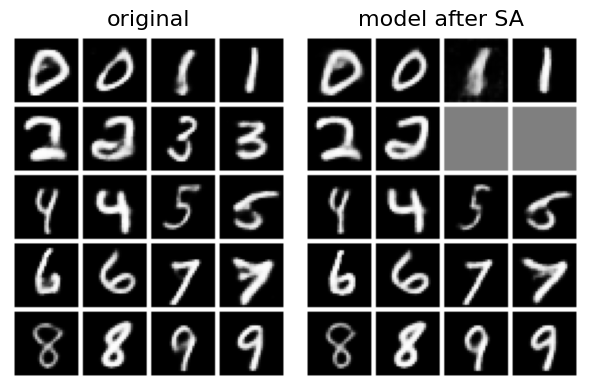

In [ ]:

# VISUAL COMPARISON (baseline vs unlearned)

import matplotlib.pyplot as plt
from torchvision import utils as vutils

def comparison_grid(baseline_model, unlearned_model,
                    rows=5, cols=4, seed=0):


    labels = []
    for d in range(NUM_CLASSES):
        labels.extend([d, d])
    labels = labels[: rows * cols]
    y = torch.tensor(labels, device=DEVICE)

    g = torch.Generator(device=DEVICE).manual_seed(seed)
    z = torch.randn(len(labels), LATENT_DIM, generator=g, device=DEVICE)


    def decode_grid(model):
        model.eval()
        with torch.no_grad():
            imgs = model.decode(z, F.one_hot(y, NUM_CLASSES).float()).cpu()
        return vutils.make_grid(imgs, nrow=cols, pad_value=1)

    grid_left  = decode_grid(baseline_model)
    grid_right = decode_grid(unlearned_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
    for a, grid, title in zip(ax, [grid_left, grid_right],
                              ["original", "model after SA"]):
        a.imshow(grid.permute(1, 2, 0), cmap="gray")
        a.set_title(title, fontsize=16)
        a.axis("off")
    plt.tight_layout()
    plt.show()

baseline   = CVAE().to(DEVICE)
baseline.load_state_dict(torch.load(CKPT_DIR / "vae_baseline.pt"))
unlearned  = CVAE().to(DEVICE)
unlearned.load_state_dict(torch.load(CKPT_DIR / f"vae_forget_{FORGET_CLASS}.pt"))

comparison_grid(baseline, unlearned)

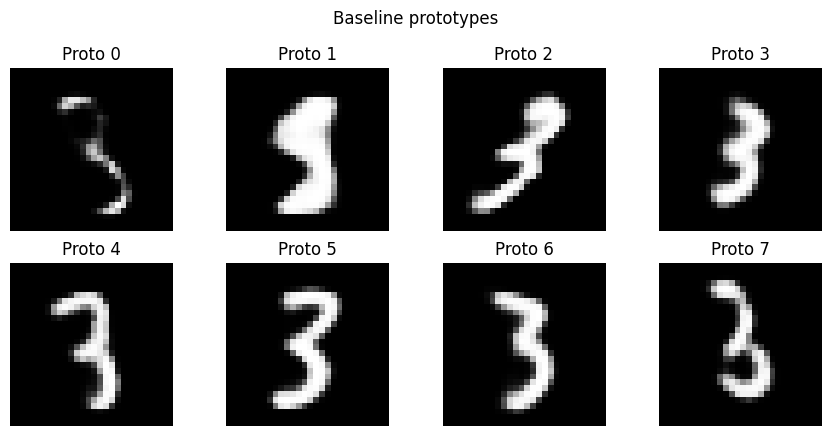

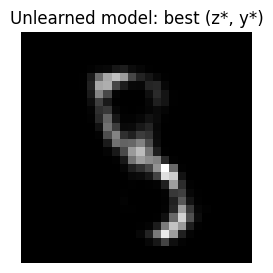

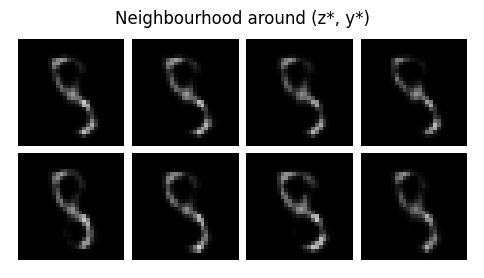

In [ ]:
# with baseline

import torch, numpy as np, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


try:
    unlearned
    baseline
except NameError:
    baseline   = CVAE().to(DEVICE)
    baseline.load_state_dict(torch.load(CKPT_DIR / "vae_baseline.pt"))
    unlearned  = CVAE().to(DEVICE)
    unlearned.load_state_dict(torch.load(CKPT_DIR / f"vae_forget_{FORGET_CLASS}.pt"))
baseline.eval(); unlearned.eval()
for p in list(baseline.parameters()) + list(unlearned.parameters()):
    p.requires_grad_(False)

# total-variation
def tv_loss(x):
    dh = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
    dv = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    return dh + dv

# Build K prototype targets for the forgotten digit from the baseline model
K_PROTOS = 8
POOL = 512
with torch.no_grad():
    z_pool = torch.randn(POOL, LATENT_DIM, device=DEVICE)
    y_forget = F.one_hot(torch.full((POOL,), FORGET_CLASS, device=DEVICE), NUM_CLASSES).float()
    imgs_pool = baseline.decode(z_pool, y_forget)
    # distance from grey
    sharpness = ((imgs_pool - 0.5)**2).mean(dim=(1,2,3))
    topk = torch.topk(sharpness, K_PROTOS).indices
    targets = imgs_pool[topk]


N_RESTARTS = 6
STEPS = 800
LR_Z = 0.06
LR_Y = 0.1
ALPHA_TV = 0.02
L2Z = 1e-3

best_loss, best_img, best_y, best_z = float('inf'), None, None, None

for r in range(N_RESTARTS):

    z = torch.randn(1, LATENT_DIM, device=DEVICE, requires_grad=True)
    y_logits = torch.zeros(1, NUM_CLASSES, device=DEVICE, requires_grad=True)

    y_logits.data[:, FORGET_CLASS] = 3.0

    opt = torch.optim.Adam([{'params':[z], 'lr':LR_Z},
                            {'params':[y_logits], 'lr':LR_Y}])

    for t in range(STEPS):
        opt.zero_grad()
        y_soft = F.softmax(y_logits, dim=1)
        out = unlearned.decode(z, y_soft)


        mse_list = ((out - targets)**2).mean(dim=(1,2,3))
        mse = torch.min(mse_list)

        # regularisers
        loss = mse + ALPHA_TV*tv_loss(out) + L2Z*(z**2).mean()
        loss.backward()
        opt.step()

        with torch.no_grad():
            z.data.clamp_(-3, 3)


    if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = out.detach()
        best_y = F.softmax(y_logits.detach(), dim=1)
        best_z = z.detach()



# Visualise

def _to_mpl_img(t):

    t = t.detach().cpu()
    if t.dim() == 4:
        t = t[0]
    if t.dim() == 3 and t.size(0) == 1:
        t = t.squeeze(0)
    if t.dim() == 3:
        t = t.permute(1, 2, 0)
    return t.clamp(0, 1)

# plot
rows = 2
cols = K_PROTOS // 2 if K_PROTOS % 2 == 0 else (K_PROTOS // 2 + 1)
fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
axes = axes.flatten()
for i in range(K_PROTOS):
    axes[i].imshow(_to_mpl_img(targets[i]), cmap="gray")
    axes[i].set_title(f"Proto {i}")
    axes[i].axis("off")

for j in range(K_PROTOS, len(axes)):
    axes[j].axis("off")
plt.suptitle("Baseline prototypes")
plt.tight_layout(); plt.show()


plt.figure(figsize=(3,3))
plt.imshow(_to_mpl_img(best_img), cmap="gray")
plt.title("Unlearned model: best (z*, y*)"); plt.axis("off"); plt.show()

# Neighbourhood around z*
with torch.no_grad():
    eps = 0.25
    zs = torch.stack([best_z + dx for dx in [
        torch.zeros_like(best_z),
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
    ]], dim=0).squeeze(1)
    ys = best_y.repeat(zs.size(0), 1)
    outs = unlearned.decode(zs, ys).cpu()

from torchvision.utils import make_grid
grid = make_grid(outs, nrow=4, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.imshow(_to_mpl_img(grid), cmap="gray")
plt.axis("off"); plt.title("Neighbourhood around (z*, y*)")
plt.show()

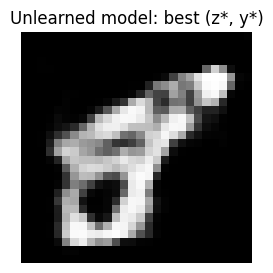

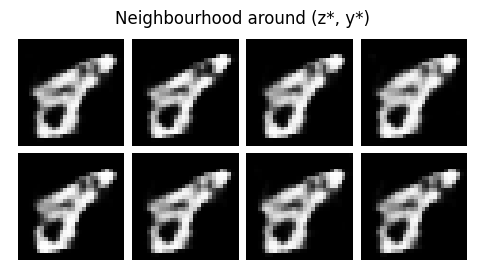

In [ ]:
# NO BASELINE with  orientation entropy
import torch, numpy as np, torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

try:
    unlearned
except NameError:
    unlearned  = CVAE().to(DEVICE)
    unlearned.load_state_dict(torch.load(CKPT_DIR / f"vae_forget_{FORGET_CLASS}.pt"))
unlearned.eval()
for p in unlearned.parameters():
    p.requires_grad_(False)

# total variation
def tv_loss(x):
    # x: [B,1,28,28], average L1 TV
    dh = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
    dv = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    return dh + dv

# orientation entropy
import math

def orientation_entropy(x, bins=8, kappa=40.0, eps=1e-8):

    kx = torch.tensor([[-1., 0., 1.],
                       [-2., 0., 2.],
                       [-1., 0., 1.]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[-1., -2., -1.],
                       [ 0.,  0.,  0.],
                       [ 1.,  2.,  1.]], device=x.device, dtype=x.dtype).view(1,1,3,3)

    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    mag = torch.sqrt(gx*gx + gy*gy + eps)
    ang = torch.atan2(gy, gx)
    ang = (ang + 2*math.pi) % (2*math.pi)

    centers = torch.arange(bins, device=x.device, dtype=x.dtype) * (2*math.pi / bins)
    ang_exp = ang.unsqueeze(-1)

    diff = torch.atan2(torch.sin(ang_exp - centers), torch.cos(ang_exp - centers))
    weights = torch.exp(-kappa * diff * diff)

    hist = (weights * mag.unsqueeze(-1)).sum(dim=(1,2,3))
    p = hist / (hist.sum(dim=1, keepdim=True) + eps)


    ent = -(p * (p + eps).log()).sum(dim=1).mean()
    return ent
    return ent


N_RESTARTS   = 12
STEPS        = 2500
LR_Z         = 0.06
LR_Y         = 0.10
W_CONTRAST   = 1.5
W_TV         = 0.04
W_INK        = 4.0
W_Z          = 1e-3
W_Y          = 2e-3
W_ORIENT     = 1.0
INK_TARGET   = 0.22

best_loss, best_img, best_y, best_z = float('inf'), None, None, None

for r in range(N_RESTARTS):
    # variables to optimise
    z = torch.randn(1, LATENT_DIM, device=DEVICE, requires_grad=True)
    y_logits = torch.zeros(1, NUM_CLASSES, device=DEVICE, requires_grad=True)
    y_logits.data[:, FORGET_CLASS] = 3.0

    opt = torch.optim.Adam(
        [{'params':[z], 'lr':LR_Z},
         {'params':[y_logits], 'lr':LR_Y}]
    )

    for t in range(STEPS):
        opt.zero_grad()
        y_soft = F.softmax(y_logits, dim=1)
        out = unlearned.decode(z, y_soft)


        contrast = ((out - 0.5)**2).mean()
        ink      = (out.mean() - INK_TARGET).pow(2)
        tv       = tv_loss(out)
        z_reg    = (z**2).mean()
        y_reg    = ((y_soft[0] - F.one_hot(
                     torch.tensor(FORGET_CLASS, device=DEVICE), NUM_CLASSES).float())**2).sum()
        orientH  = orientation_entropy(out, bins=8, kappa=40.0)

        loss = (W_TV*tv + W_INK*ink + W_Z*z_reg + W_Y*y_reg) \
             - (W_CONTRAST*contrast + W_ORIENT*orientH)

        loss.backward()
        opt.step()
        with torch.no_grad():
            z.data.clamp_(-3, 3)


    if loss.item() < best_loss:
        best_loss = loss.item()
        best_img  = out.detach()
        best_y    = F.softmax(y_logits.detach(), dim=1)
        best_z    = z.detach()


def _to_mpl_img(t):
    t = t.detach().cpu()
    if t.dim() == 4: t = t[0]
    if t.dim() == 3 and t.size(0) == 1: t = t.squeeze(0)
    if t.dim() == 3: t = t.permute(1, 2, 0)
    return t.clamp(0, 1)


plt.figure(figsize=(3,3))
plt.imshow(_to_mpl_img(best_img), cmap="gray")
plt.title("Unlearned model: best (z*, y*)"); plt.axis("off"); plt.show()

with torch.no_grad():
    eps = 0.25
    zs = torch.stack([best_z + dx for dx in [
        torch.zeros_like(best_z),
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
        torch.randn_like(best_z)*eps,
    ]], dim=0).squeeze(1)
    ys = best_y.repeat(zs.size(0), 1)
    outs = unlearned.decode(zs, ys).cpu()

grid = make_grid(outs, nrow=4, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.imshow(_to_mpl_img(grid), cmap="gray")
plt.axis("off"); plt.title("Neighbourhood around (z*, y*)")
plt.show()